EE4483 Mini Project - NLP Sentiment Analysis 

1. Import necessary library for data processing and basic information collection

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

a) Read data from provided json files

In [2]:
train_df = pd.read_json('train.json')
print(train_df.shape)
train_df.head()

(7401, 2)


,reviews,sentiments
0,I bought this belt for my daughter in-law for ...,1
1,The size was perfect and so was the color. It...,1
2,"Fits and feels good, esp. for doing a swim rac...",1
3,These socks are absolutely the best. I take pi...,1
4,Thank you so much for the speedy delivery they...,1


In [3]:
test_df = pd.read_json('test.json')
print(test_df.shape)
test_df.head()

(1851, 1)


,reviews
0,I bought 2 sleepers. sleeper had holes in the...
1,I dare say these are just about the sexiest th...
2,"everything about the transaction (price, deliv..."
3,"Not bad for just a shirt. Very durable, and m..."
4,These are truly wrinkle free and longer than t...


In [4]:
train_df["sentiments"].value_counts()

1    6319
0    1082
Name: sentiments, dtype: int64

In [5]:
train_df["reviews"][3]

'These socks are absolutely the best. I take pilates classes and if it is hot your feet can slip off the mat. (Not good in the middle of a side plank!)Anyway these socks keep your feet planted and dry. One note; make sure not to order them big, the idea is that they should be snug'

b) Count the numbers of samples in each of the categories.

<Axes: xlabel='sentiments', ylabel='count'>

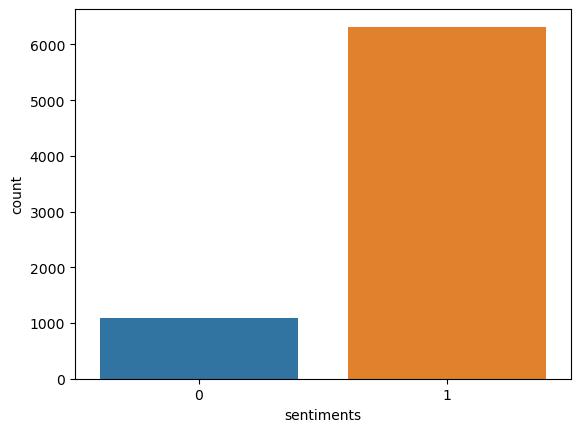

In [6]:
import seaborn as sns
sns.countplot(x='sentiments', data=train_df)

2. Data processing

In [7]:
tweet = train_df.reviews.values
type(train_df)
type(tweet)

numpy.ndarray

Tokenize the words in the tweet array, assign a unique number to each different word.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)

Change the words into numbers which we assigned just now.

In [9]:
encoded_docs = tokenizer.texts_to_sequences(tweet)
type(encoded_docs)

list

Pad the sequences into same length and convert it back to numpy.ndarray for training.

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequence = pad_sequences(encoded_docs, maxlen=200)
type(padded_sequence)

numpy.ndarray

3. Model training.

In [11]:
vocab_size = len(tokenizer.word_index) + 1

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

Model details

In [13]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array.

In [14]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           468192    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 484,843
Trainable params: 484,843
Non-trainable params: 0
_________________________________________________________________
None


Process sentiment label for training.

In [15]:
sentiment_label = train_df.sentiments.values
sentiment_label

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

Use training data to train the model. Meanwhile, split out a group of data for validation.

In [16]:
history = model.fit(padded_sequence,sentiment_label,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
185/185 [==============================] - 21s 112ms/step - loss: 0.4055 - accuracy: 0.8519 - val_loss: 0.3495 - val_accuracy: 0.8575
Epoch 2/10
185/185 [==============================] - 19s 103ms/step - loss: 0.2398 - accuracy: 0.9034 - val_loss: 0.2829 - val_accuracy: 0.9014
Epoch 3/10
185/185 [==============================] - 19s 103ms/step - loss: 0.1614 - accuracy: 0.9368 - val_loss: 0.2785 - val_accuracy: 0.9082
Epoch 4/10
185/185 [==============================] - 19s 105ms/step - loss: 0.1327 - accuracy: 0.9522 - val_loss: 0.3442 - val_accuracy: 0.9028
Epoch 5/10
185/185 [==============================] - 19s 105ms/step - loss: 0.1101 - accuracy: 0.9601 - val_loss: 0.3827 - val_accuracy: 0.9061
Epoch 6/10
185/185 [==============================] - 20s 107ms/step - loss: 0.0789 - accuracy: 0.9748 - val_loss: 0.2940 - val_accuracy: 0.9055
Epoch 7/10
185/185 [==============================] - 20s 108ms/step - loss: 0.0779 - accuracy: 0.9733 - val_loss: 0.3668 - val_ac

Plot the accuracy for training and validation set. Label as "acc" and "val_acc".

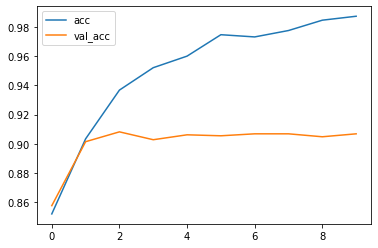

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

Plot the loss for training and validation set. Label as "loss" and "val_loss".

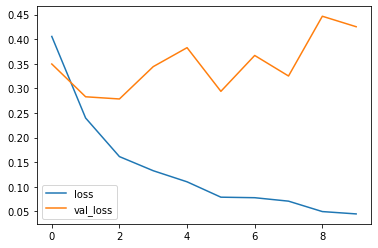

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

4. Predict the test json using the model trained just now.

Process test data.

In [19]:
test_sentences = list(test_df['reviews'])

Define a function to predict result.

In [20]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    return prediction

For each element in the test_df, use the function to do predictions and store the results into a new list Y.

In [21]:
Y = []
for text in test_sentences:
    Y.append(predict_sentiment(text))

In [23]:
type(Y)

list

Append the result list into to the test data frame and show the final data frame.Output the data frame as a csv file.

In [24]:
test_df["predictions"] = Y
test_df.head()

,reviews,predictions
0,I bought 2 sleepers. sleeper had holes in the...,0
1,I dare say these are just about the sexiest th...,1
2,"everything about the transaction (price, deliv...",1
3,"Not bad for just a shirt. Very durable, and m...",1
4,These are truly wrinkle free and longer than t...,1


In [25]:
test_df.to_csv('submission_XiaoYuxuan.csv')

A brief cover on the prediction result.

<AxesSubplot:xlabel='predictions', ylabel='count'>

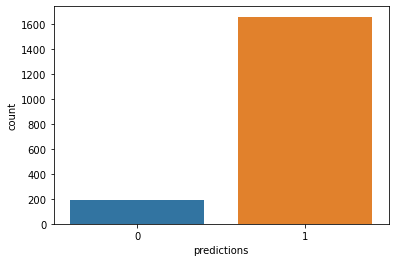

In [26]:
sns.countplot(x='predictions', data=test_df)